## Face Feature Extraction

In [1]:
# importing Libraries 

import numpy as np
import sklearn
from time import time
import logging
import matplotlib.pyplot as plt

# %matplotlib inline

In [3]:
#Importing dataset and classifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


In [4]:
#Downloading Datasets

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# finding the shape of images
n_samples, h, w = lfw_people.images.shape


X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)



Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


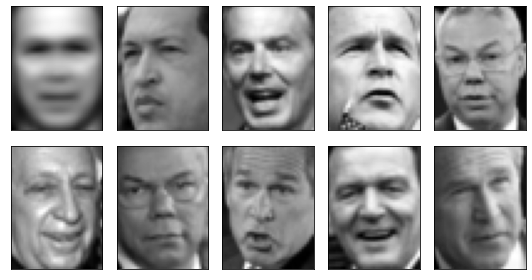

In [5]:
# Plotting Sample faces and average faces

def plot_faces(images, n_row=2, n_col=5):
    plt.figure(figsize=(1.5 * n_col, 2.2 * n_row))
    plt.subplots_adjust(0.6, 0.5, 1.5, 1.5)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.tight_layout()
    plt.show()
    

Xmean = np.mean(X,axis=0).reshape(1,n_features) #average face
plot_faces(np.concatenate((Xmean,X[:9]),axis=0))

In [6]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

Extracting the top 50 eigenfaces from 1030 faces


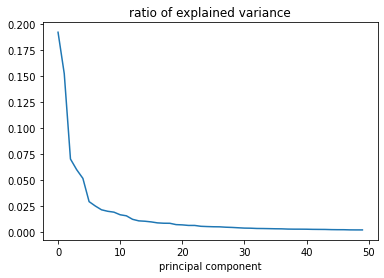

In [7]:
#Computing PCA and extracting n eigen faces

n_components = 50

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
# print("done in %0.3fs" % (time() - t0))


f,ax = plt.subplots()
plt.plot(pca.explained_variance_ratio_)
plt.title("ratio of explained variance")
ax.set_xlabel("principal component")
plt.show()


Projecting the input data on the eigenfaces orthonormal basis


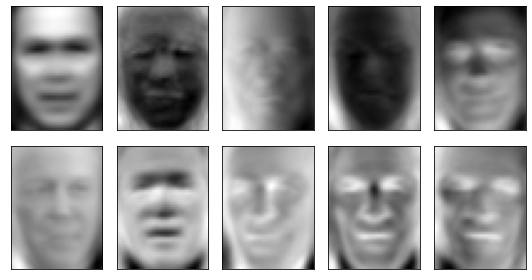

In [8]:
#plot the average face and top eigenfaces

eigenfaces = pca.components_.reshape((n_components, h, w))
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#Using mean function to fing the eigen faces
Xmean = pca.mean_.reshape(1,n_features)
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

eigenfaces = pca.components_
plot_faces(np.concatenate((Xmean,eigenfaces[:10]),axis=0))

In [9]:
#Training SVM Classifier

t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

done in 16.542s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)


In [10]:
#evaluating on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
# print("done in %0.3fs" % (time() - t0))

# print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
[[  8   0   2   1   0   0   0]
 [  0  42   0   2   0   0   3]
 [  0   2  14   5   1   0   0]
 [  0   4   4 105   2   1   3]
 [  0   0   1   3  13   2   0]
 [  0   2   0   1   0   9   1]
 [  1   3   0   2   2   0  19]]


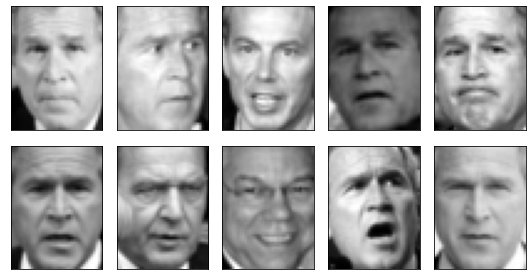

In [11]:
#original faces
plot_faces(X_test[:10])

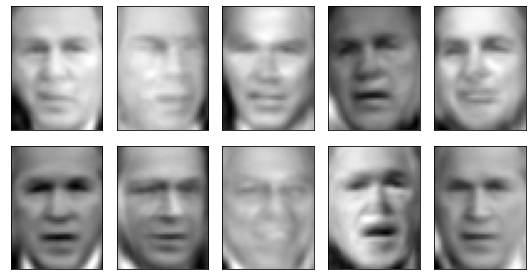

In [12]:
#reconstructed faces
X_test_rec = pca.inverse_transform(X_test_pca)
plot_faces(X_test_rec[:10])

In [13]:
def plot_gallery(images, titles, h, w, n_row=1, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

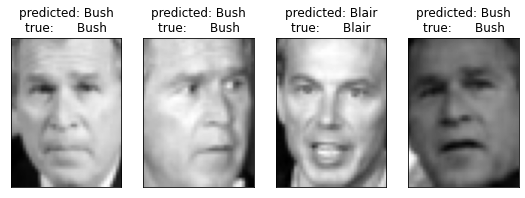

In [14]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

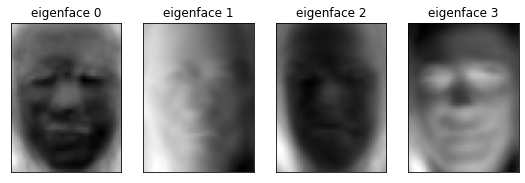

In [15]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()